# What to Watch?



Para el desarrollo de este ejercicio el profesor Alexander pide lo siguiente:

1. Desarrollar un sistema de recomendación de peliculas basado en la información proporcionada.
2. Realizar un analisis y descripción de la información presentada utilizando herramientas de aprendizaje no supervisado. ¿Qué puede decir de los datos y su distribución?, ¿qué grupos pueden encontrar?, ¿qué indican esos grupos?, etc...

¿Qué se debe entregar?

1. Analisis de la información presentada. ¿Qué se puede inferir de los datos?
2. Implementación y explicación del sistema de recomendación. Análisis de los resultados del sistema de recomendación utilizando un ejemplo.
3. ¿Cómo puedo evaluar que peliculas le podrian gustar a un usuario nuevo (que no este en la base de datos) basado en las calificaciones que este da a una serie de peliculas?
4. Análisis sobre como incorporar toda la información otorgada.
5. ¿Qué se puede inferir sobre los diferentes usuarios y sus gustos en peliculas? se puede encontrar alguna relación entre edad, profesión, sexo y genero de peliculas que les gusta a estos grupos? ¿Cómo se podria obtener esta información?
6. Durante el desarrollo de cada uno de los puntos del taller indique los métodos utilizados y explique la forma como los utiliza.
7. Una discusión sobre el desarrollo del proyecto, los metodos utilizados, posibles mejoras, etc..




Ademas el profesor pide que contesten las siguientes preguntas:




Finalmente, el profesor Alexander les pide que entreguen el notebook de jupyter con el material de apoyo necesario, el código documentado con el análisis de cada una de las partes, y las respuestas a las preguntas realizadas. Al entregar el notebook, por favor use la convención Número_de_grupo_No_Supervisado.

Recuerde colocar los nombres de los participantes al comienzo del notebook que entregan.

Nota: Recuerden que tienen hasta el **Domingo 31 de Octubre** a las 12 de la noche para entregar sus notebooks. Mucha suerte!!




# What to Watch?

Debido a la pandemia el profesor Alexander no ha tenido tiempo de ver peliculas. Sin embargo, ya que el semestre llegará a su fin dentro de poco, el quisiera tener un sistema de recomendación que le indique que peliculas le podrian gustar. Para esto pensó que, como sus estudiantes de Machine Learning tienen conocimiento de diferentes técnicas de aprendizaje no supervisado, sería una buena oportunidad para evaluar sus conocimiento en esta area.

El profesor encontro una base de datos de ratings de peliculas, la descripción pueden encontrala [aquí](https://grouplens.org/datasets/movielens/100k/), y los archivos estan adjuntos en la carpeta del taller. Esta base de datos cuenta con la calificación de 943 usuarios a 1682 peliculas, en total se dispone de mil califiicaciones (entre 0 y 5). Ademas de la lista que relaciona al usuario con la pelicula y el rating dado, el profesor cuenta con información sobre el genero al que pertenece la pelicula (una clasificación de 19 generos diferentes), asi mismo como información relacionada con edad, sexo, y profesion de los diferents usuarios.

Para este ejercicio el profesor Alexander no quiere probar solamente el conocimiento de sus estudiantes en el desarrollo de sistemas de recomendación, sino en el uso de diferentes tecnicas de aprendizaje no supervisado. Por lo tanto se deben emplear diferentes técnicas de las vistas en clase. Para este proyecto el profesor cuenta con la siguiente información en diferentes archivos de excel:

1. **u_data_ratings.xls**: rating de peliculas asignado por un usuario a una pelicula especifica.
2. **u_movies_genre.xls**: enumeración de los 20 diferentes generos de peliculas incluidos en la base de datos.
3. **u_movies_items.xls**: un archivo que contiene información relacionada con cada una de las peliculas.
5. **u_user_info.xls**: información relacionada a los usuarios.

Importamos las librerías necesarias para el proyecto.

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings("ignore")

Leemos los datos de la carpeta `data` que son los `raitings`, `movies` y `user_info` organizándolo con sus respectivos nombres de columnas y de indices.

In [2]:
# Raitings
raitings = pd.read_csv('data/u.data', sep='\t', header = None)
raitings.columns = ['user_id', 'item_id', 'rating', 'timestamp']

# Movies
movies = pd.read_csv('data/u.item', sep='|', header = None, encoding='latin-1')
movies.columns = ["movie_id","movie_title","release_date","video_release_date","IMDb_URL","unknown",
                "Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy",
                "Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]
movies.index = movies['movie_id']
movies = movies.drop(["movie_id","video_release_date","IMDb_URL"], axis = 1)

# Genres
genre = pd.read_csv('data/u.genre', sep='|', header = None, encoding='latin-1')
genre.columns = ['genre', 'genre_id']

# User_info
user_info = pd.read_csv('data/u.user', sep='|', header = None, encoding='latin-1')
user_info.columns = ["user_id", "age", "gender", "occupation", "zip_cod"]
user_info.index = user_info['user_id']
user_info = user_info.drop(['user_id'], axis = 1)

In [3]:
genre

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


Creamos la matriz X que contiene en las columnas los usuarios, en las filas las peliculas y sus valores son los raitings que los usuarios dieron a cierta película. Cuando no hay un raiting proporcionado por el usuario, este valor es 0.

In [4]:
V = np.zeros((movies.shape[0], user_info.shape[0]))
for q in np.array(raitings):
    V[q[1]-1,q[0]-1] = q[2]
    
X = pd.DataFrame(V, columns=user_info.index)
X.index = movies.index

In [5]:
X.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
2,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Utilizamos la factorización no negativa de matrices con 16 componentes y la entrenamos.

In [6]:
n = 16
nmf = NMF(n)
nmf.fit(X)

NMF(n_components=16)

Hallamos las matrices $H$ y $W$ con los resultados anteriormente obtenidos de la factorización.

In [7]:
H = pd.DataFrame(np.round(nmf.components_,2), columns=X.columns)

W = pd.DataFrame(np.round(nmf.transform(V),2), columns=H.index)
W.index = X.index

Note que la matriz $H$ tiene todas las componentes en las filas y cada uno de los usuarios en las columnas. Con esto podemos determinar el género, la profesión y las edades que más predominan en los usuarios por cada una de las componentes.

In [9]:
H

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,0.30,0.04,0.00,0.00,0.00,0.00,0.93,0.00,0.00,0.12,...,0.00,0.07,0.00,0.00,0.00,0.09,0.11,0.00,0.16,0.52
1,0.00,0.29,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.00,...,0.00,1.26,0.81,0.00,1.80,1.18,0.00,0.34,0.00,0.36
2,1.08,0.04,0.00,0.00,0.00,0.81,0.41,0.00,0.00,0.62,...,0.75,0.00,0.02,0.11,0.00,0.00,0.33,0.00,0.00,0.00
3,0.15,0.00,0.00,0.00,0.39,0.29,0.96,0.00,0.00,0.15,...,0.58,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.50,0.00
4,0.00,0.14,0.75,0.78,0.00,0.00,0.20,0.25,0.11,0.05,...,0.00,0.00,0.38,0.22,0.53,0.00,0.40,0.23,0.41,0.00
5,0.32,0.00,0.00,0.02,0.44,0.00,0.61,0.00,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.80
6,1.53,0.00,0.00,0.00,1.59,0.13,0.59,0.05,0.00,0.00,...,0.56,0.00,0.00,0.00,0.06,0.00,0.24,0.24,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,1.26,2.07,0.00,0.15,1.19,...,0.65,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.62,0.00
8,0.71,0.00,0.00,0.00,0.17,0.00,1.20,1.21,0.00,0.06,...,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99
9,0.27,0.00,0.00,0.01,0.42,0.00,1.26,0.00,0.02,0.32,...,0.00,0.00,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.41


Así, con la información proporcionada por la matriz $H$, logramos identificar las edades, ocupaciones y géneros más predominantes de las componentes. Con la siguiente función, identificamos los 60 usuarios en la matriz $H$ que tienen meyor puntuación por componente y con esto obtuvimos las edades, ocupaciones y géneros de estos usuarios.

In [10]:
def age_gender_occupation_comp(index_comp):
    comp = H.sort_values(by = index_comp,ascending=False, axis = 1).iloc[index_comp,:60]
    index = comp.index
    comp = np.column_stack((comp, np.zeros((comp.shape[0], 3))))
    comp = pd.DataFrame(comp, index = index)
    comp.columns = ['raiting','age', 'gender', 'occupation']
    for idx, id_item in enumerate(comp.index):
        s = user_info[user_info.index == id_item]
        comp.iloc[idx,1] = s['age']
        comp.iloc[idx,2] = s['gender']
        comp.iloc[idx,3] = s['occupation']
    return comp

Luego, utilizamos la función antes creada para hallar las edades que más predominan en cada una de las componentes, guardando estos resultados en la lista `comp_age`.

In [11]:
comp_age = []
for j in range(n):
    list_age = age_gender_occupation_comp(j)['age'].values.tolist()
    dict_age = {list_age.count(q):q for q in list_age}
    list_age = []
    for i in dict_age.keys():
        if i >= 4:    
            list_age.append(dict_age[i])
    list_age.sort()
    comp_age.append(list_age)

Similar al proceso anterior, creamos las listas `comp_gender` y `comp_occupation` que obtienen los géneros y las ocupaciones más predominantes por componente, respectivamente.

In [12]:
comp_gender = []
comp_occupation = []
for j in range(n):
    list_gender = age_gender_occupation_comp(j)['gender'].values.tolist()
    list_occupation = age_gender_occupation_comp(j)['occupation'].values.tolist()
    dict_gender = {list_gender.count(q):q for q in list_gender}
    comp_gender.append(dict_gender[max(dict_gender.keys())])
    dict_occupation = {list_occupation.count(q):q for q in list_occupation}
    comp_occupation.append(dict_occupation[max(dict_occupation.keys())])

Observemos la matriz $W$.

In [13]:
W

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
movie_id,,,,,,,,,,,,,,,,
1,0.00,2.03,0.00,1.89,0.00,0.00,1.54,0.00,0.00,0.00,1.20,0.24,1.16,0.08,0.00,0.00
2,0.03,0.00,0.00,0.06,0.00,0.83,0.32,0.00,1.45,0.00,0.00,0.03,0.06,0.17,0.00,0.00
3,0.00,0.37,0.00,0.00,0.00,0.63,0.04,0.00,0.00,0.00,0.08,0.00,0.00,1.10,0.00,0.00
4,0.50,0.00,0.00,0.00,0.00,0.53,0.18,0.07,0.86,0.00,0.00,1.19,0.36,1.40,0.03,0.06
5,0.32,0.17,0.00,0.00,0.00,0.23,0.00,0.00,0.06,1.73,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00
1679,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00
1680,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00


Esta matriz tiene en las filas cada una de las películas en la base de datos y en las columnas cada una de las componentes. Con esta información y similar a los procesos anteriores, se identificarán los géneros de las películas que más predominan por componente. Para esto se creó la siguiente función que con el indice de la componente ubica las 20 mejores películas por componente y retorna un DataFrame que contiene las 20 películas y sus respectivos géneros.

In [14]:
def best_movies_comp(index_comp):
    comp = W.sort_values(by = index_comp,ascending=False).iloc[:20, index_comp]
    index = comp.index
    comp = np.column_stack((comp, np.zeros(comp.shape[0])))
    comp = pd.DataFrame(comp, index = index)
    comp.loc[:,1] = comp.loc[:,1].astype('object')
    comp.columns = ['raiting','genres']
    for idx, id_item in enumerate(comp.index):
        s = movies[movies.index == id_item]
        genre_list = []
        for i in s:
            if s.loc[:,i].values == 1:
                genre_list.append(i)
        comp.iat[idx,1] = genre_list
    return comp

Luego de esto, se procedió a utilizar la función para cada una de las componentes y a identificar por género cuáles son los géneros que predominan en las componentes. Esta información se almacenó en la lista `comp_genres`. 

In [15]:
comp_genres = []
for j in range(n):
    list_genre = [q for i in best_movies_comp(j)['genres'].values.tolist() for q in i]
    dict_genre = {list_genre.count(q):q for q in list_genre}
    comp_genres.append(dict_genre[max(dict_genre.keys())])

De esta manera, utilizando todos los elementos encontrados anteriormente, logramos hacer un DataFrame que contiene las componentes y toda la información encontrada en cada una de ellas.

In [16]:
componentes = np.zeros((10,4))
componentes = pd.DataFrame(componentes)
componentes.loc[:,:] = componentes.loc[:,:].astype('object')
for i in range(n):
    componentes.loc[i,:] = ([comp_age[i], comp_gender[i], comp_occupation[i], comp_genres[i]])
componentes.columns = ['age', 'gender', 'occupation', 'genre']
componentes

,age,gender,occupation,genre
0,"[35.0, 51.0]",M,student,Drama
1,"[20.0, 22.0, 26.0]",M,student,Action
2,"[27.0, 50.0]",M,educator,Drama
3,"[27.0, 38.0]",M,other,Children's
4,"[22.0, 55.0]",M,student,Thriller
5,"[19.0, 22.0, 24.0, 25.0]",M,student,Comedy
6,"[26.0, 27.0, 33.0]",M,student,Comedy
7,"[35.0, 36.0]",M,educator,Thriller
8,"[20.0, 25.0]",M,student,Action
9,"[19.0, 27.0]",M,student,Horror


Además, por usuario creamos una función que otorga una lista de los géneros que más le gustan a un usuario en particular. Esto gracias al id de este.

In [17]:
def user_genres(user_id):
    comp = H.sort_values(by=user_id, ascending=False).loc[:,user_id]
    user_genre = []
    for i in comp.index:
        if comp[i] > 0.6:
            user_genre.append(comp_genres[i])
    return list(set(user_genre))

Ahora teniendo toda la información anterior, procedemos a obtener la matriz reconstruida gracias al NMF.

In [18]:
reconstructed = pd.DataFrame(np.round(np.dot(W,H),2), columns=X.columns)
reconstructed.index = X.index

Creamos una función `recommended_movies` que recibe el id del usuario y el número de películas que desea recomendar. De esta manera, tomamos por columna las peliculas que serían mejor puntuadas por el usuario y quitamos aquellas que había visto. Luego, con esta respuesta la idea es analizar la recomendación e identificar si es apropiada para el usuario correspondiente.

In [19]:
def recommended_movies(user_id, num):
    count = 0
    comp = reconstructed.sort_values(by=user_id, ascending=False).loc[:,user_id]
    recommended = np.zeros((num,1))
    index_array = []
    while True:
        for item_id in comp.index:
            if count == num:
                break
            if X.loc[item_id, user_id] == 0:
                recommended[count] = comp.loc[item_id]
                count += 1
                index_array.append(item_id)
        if count == num:
            break
            
    recommended = np.column_stack((np.zeros(recommended.shape[0]), recommended, np.zeros(recommended.shape[0])))
    recommended = pd.DataFrame(recommended, index = index_array)
    recommended.loc[:,1] = recommended.loc[:,1].astype('object')
    recommended.columns = ['movie_title','raiting','genres']
    for idx, id_item in enumerate(recommended.index):
        s = movies[movies.index == id_item]
        genre_list = []
        for i in s:
            if s.loc[:,i].values == 1:
                genre_list.append(i)
        recommended.iat[idx,0] = s['movie_title'].values[0]
        recommended.iat[idx,2] = genre_list
        
    return recommended

## Preguntas
**1. Analisis de la información presentada. ¿Qué se puede inferir de los datos?**

Al realizar el análisis con las 16 componentes elegidas, pudimos identificar que de los datos podemos inferir que la mayoría de los datos recolectados son del género masculino. Además, la ocupación que más predomina son los estudiantes y los usuarios de la base de datos están más que todo en los rangos de 20 y 40 años. Con esto, podemos inferir que la recomendación de las peliculas para los usuarios será más correcta para los estudiantes que estén entre 20 y 40 años. 

De la misma manera, al analizar la información recolectada notamos que el género que más predomina en la base de datos es el Drama y un poco de comedia. En el Drama, identificamos que las personas que ven mayormente drama son estudiantes, administradores y bibliotecarios. Si son estudiantes la edad predominante va entre los 18 y 30 años. Si son administradores, la edad es 51. Y si son bibliotecarios está al rededor de los 27 años. Además, una de las componentes nos indica que el género femenino ve peliculas de romance, con un rango de edad de 27 a 35 años y estudiantes. 

Toda la información antes indicada se puede observar en el siguiente DataFrame:

In [20]:
componentes

,age,gender,occupation,genre
0,"[35.0, 51.0]",M,student,Drama
1,"[20.0, 22.0, 26.0]",M,student,Action
2,"[27.0, 50.0]",M,educator,Drama
3,"[27.0, 38.0]",M,other,Children's
4,"[22.0, 55.0]",M,student,Thriller
5,"[19.0, 22.0, 24.0, 25.0]",M,student,Comedy
6,"[26.0, 27.0, 33.0]",M,student,Comedy
7,"[35.0, 36.0]",M,educator,Thriller
8,"[20.0, 25.0]",M,student,Action
9,"[19.0, 27.0]",M,student,Horror


**2. Implementación y explicación del sistema de recomendación. Análisis de los resultados del sistema de recomendación utilizando un ejemplo.**

El sistema de recomendación funciona de la siguiente manera: 
  1. Definimos 16 componentes para utilizar la Factorización No Negativa de matrices.
  2. Separamos las matrices $W$ y $H$ y las analizamos cuidadosamente.
  3. Obtenemos la matriz reconstruida con las dos matrices anteriores.
  4. Recomendamos el número de peliculas que se quieran con el id del usuario y decide cuánto podría gustar esta película al usuario.
  5. Evaluamos la recomendación con la información del usuario recomendada.

Para el ejemplo utilizaremos el usuario con id 270. Note que la información del usuario es la siguiente:

In [21]:
user_id = 270
df = user_info[user_info.index == user_id].copy()
df['genres'] = 0
df['genres'] = df['genres'].astype('object')
df.at[user_id,'genres'] = user_genres(user_id)
df = df.drop(['zip_cod'], axis = 1)
df

,age,gender,occupation,genres
user_id,,,,
270,18,F,student,"[Drama, Horror]"


Utilizamos la función `recommended_movies` y recomendamos las primeras 5 peliculas.

In [22]:
recommended_movies(user_id, 5)

,movie_title,raiting,genres
100,Fargo (1996),4.18,"[Crime, Drama, Thriller]"
436,"American Werewolf in London, An (1981)",3.98,[Horror]
448,"Omen, The (1976)",3.96,[Horror]
14,"Postino, Il (1994)",2.53,"[Drama, Romance]"
201,Evil Dead II (1987),2.45,"[Action, Adventure, Comedy, Horror]"


Note que las peliculas recomendadas corresponden a los generos que le gustan al usuario. Además, note que el usuario es una mujer, estudiante de 18 años. Con el análisis de los componentes, podemos identificar que le gusta el romance y por ende sale la recomendación número 4. Además. note que las posibles calificaciones de las 3 primeras recomendaciones son similares entre sí. 

Por todo lo anterior, la recomendación para el usuario 270 es bastante buena.

**3. ¿Cómo puedo evaluar que peliculas le podrian gustar a un usuario nuevo (que no este en la base de datos) basado en las calificaciones que este da a una serie de peliculas?**

Para evaluar qué peliculas le podrían gustar a un usuario nuevo se tendría que buscar y filtrar los usuarios que tienen características similares. En este caso, un factor importante de decisión sería la edad, dado que, como anteriormente vimos, las ocupaciones de los usuarios son en su mayoría estudiantes y no representaría una gran distinción. Lo mismo pasa con el género dado que en este también su mayoría son hombres.

Luego de tener los posibles candidatos, se detectaría si los géneros que les gustan a los usuarios son los mismos o parecidos a los del usuario nuevo y con ello se podría determinar la mejor similitud a uno de los usuarios de la base de datos otorgada. Después, se utilizarían las posibles recomendaciones del usuario y se filtrarían nuevamente con los géneros que le gustan al usuario nuevo.

**4. Análisis sobre como incorporar toda la información otorgada.**

Teniendo en cuenta los datos proporcionados, se crea una matriz principal $X$, la cual contiene información sobre cada película y cada usuario. La información que nos muestra, es el raiting con el cual se puntúa en cada una. En caso de que el usuario no la haya visto, el puntaje será de cero. De esta forma, se parte principalmente para realizar el sistema de recomendación, evidenciando el sesgo que tiene cada persona a la hora de ver las películas. 

**5. ¿Qué se puede inferir sobre los diferentes usuarios y sus gustos en peliculas? ¿se puede encontrar alguna relación entre edad, profesión, sexo y genero de peliculas que les gusta a estos grupos? ¿Cómo se podria obtener esta información?** 

A partir de la información recolectada, podemos inferir que la relación que más predomina son los estudiantes entre 18 y 30 años. Estas personas tienen una preferencia hacia el Drama.  
Como se dijo anteriormente, podemos evidenciar que una de las relaciones más notorias es entre la profesión y la edad. Por otro lado, también se evidenció una relación entre sexo y el género de las películas. Las mujeres tienen un tendencia hacia las películas románticas.
 
Ahora bien, se logró hacer un filtro en donde podemos evidenciar cual cual es el comportamiento de cada variable que se considera teniendo en cuenta cada persona y el género de la película. Esto se puede evidenciar en la tabla llamada `componentes`.

**6. Durante el desarrollo de cada uno de los puntos del taller indique los métodos utilizados y explique la forma como los utiliza.**


Para el proyecto, el método o algoritmo que se utilizó principalmente fue la `Factorización no negativa de matrices (NMF)`. Este busca que a la hora de descomponer los elementos, estos no resulten negativos y de esta manera, se logre analizar y agrupar datos.

Ahora bien, en el proyecto, el algoritmo fue usado para lograr factorizar la matriz general teniendo en cuenta carcaterísticas específicas. Puntualmente, utilizamos la matriz $X$, que es la que contiene el raiting dados los usuarios y las películas, para así lograr filtrar la información y trabajar en ella. Esto se logra, teniendo en cuenta los datos que más predominan y se dividen agrupándose en la cantidad de componentes que se requiere. En este caso, la cantidad de componentes eran 16, por lo tanto y por medio de `NMF`, obtuvimos una simplificación de los datos. Ahora bien, esta simplificación se divide en dos matrices principales: $H$ y $W$.


La matriz $W$ nos indica la relación entre cada película y las categorías con las que estamos trabajando. De esta manera, se logra clasificar cada película a que categoría podría ser catalogada. Por otro lado, la matriz $H$ contiene la relación que hay entre cada usuario y cada componente, para así lograr descifrar, que tipo de género predomina en los gustos de cada usuario.



**7. Una discusión sobre el desarrollo del proyecto, los metodos utilizados, posibles mejoras, etc..**

Como se ha dicho anteriormente, el método principal utilizado fue la factorización no negativa de matrices, con esta sólo quedaba reconstruir la matriz original para la recomendación de peliculas y poder analizar cada una de las componentes. Para esto, se utilizaron las funciones mencionadas durante todo el notebook que tienen como finalidad obtener nueva información del usuario que no está explícita en los datos originales, y poder observar si la recomendación realizada es la correcta. 

Las posibles mejoras serían hacer un nuevo filtrado con la información antes mencionada para que la recomendación sea mejor para cada uno de los usuarios. Así, no sólo nos basaríamos en la matriz reconstruida, si no, que quitaríamos algunas sugerencias que tal vez no le gusten al usuario, tal vez, por el género de la pelicula. Así mismo, identificar los usuarios similares y tomar algunas recomendaciones que estos tengan para recomendar a sus similares, sería buena idea para implementar en las recomendaciones.

# Paint it

El profesor Alexander, además de dedicarse a Netflix en sus vacaciones, quiere también retomar su interes por el arte. Para esto el requiere que los estudiantes de Machine Learning le colaboren con sus conocimientos en cuantización de Color. Debido a la pandemia el profesor no ppuede salir a comprar pinturas, y su paleta de colores es bastante limitada, menos de 20 tonos. Por esta razón, el profesor pide que utilicen las obras de arte que se adjuntan en la carpeta de imágenes, y realicen un proceso de cuantización de color con mapas autoorganizados. Para este proceso deben seguir tener en cuenta:

1. ¿Cuantos colores van a utilizar?
2. ¿Cuál es la mejor pintura que el profesor podria realizar con los colores que ustedes proponen?
3. Mostrar como se verian las pinturas utilizando solamente la limitada paleta de la cual dispone el profesor.
4. Para este taller podemos utilizar la libreria simpSOM, domumentación sobre la libreria pueden encontrarla [aquí](https://github.com/fcomitani/SimpSOM). O esta otra que esta implementada en Python, pero basada en la libreria de MATLAB [aquí](https://github.com/sevamoo/SOMPY).

Importamos las librerías necesarias. Para el los mapas autorganizados utilizamos la librería tinySOM que está en la misma carpeta.

In [18]:
from tinySOM import *
import os
from skimage.io import imread, imshow, imsave
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.metrics import pairwise_distances

Leemos las imágenes y las almacenamos en la lista `images`.

In [19]:
images = []
for file in os.listdir('./Imagenes'):
    im = imread('./Imagenes/' + file)
    images.append(im)

Definimos la función `image_transformed` que retorna la imagen cuantificada con respecto a la imagen original. Aquí escogemos que la cantidad de colores a usar es 20, dado que la paleta de colores es de máximo 20 tonos.

In [22]:
def image_transformed(im):
    data = im.reshape((im.shape[0]*im.shape[1], 3))
    data = data / data.max()
    test_map = Map((5,4),3, 0.01)
    test_map.fit(data, 10000)
    weights_t = test_map.weights.reshape(test_map.weights.shape[0]*test_map.weights.shape[1],3)
    image_trans = np.zeros(data.shape)
    
    distance_index = pairwise_distances(data, weights_t).argmin(axis = 1)

    for idx, i in enumerate(distance_index):
        image_trans[idx, :] = weights_t[i]
        
    image_trans = image_trans.reshape(im.shape[0], im.shape[1], 3)
    
    fig, ax = plt.subplots(1,2, figsize = (20,20))
    ax[0].imshow(im)
    ax[0].set_title('Imagen Original', fontsize=30)
    ax[1].imshow(image_trans)
    ax[1].set_title('Imagen Cuantificada', fontsize=30)
    
    
    fig2, ax2 = plt.subplots(figsize = (20,5))
    im_paleta = ndimage.rotate(test_map.weights.reshape((20, 1, 3)), 90)
    ax2.set_title('Paleta de Colores', fontsize=30)
    ax2.imshow(im_paleta)

Observamos canda una de las imágenes, comparandólas con la imagen original, la cuantificada y la respectiva paleta de colores de esta última.

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7477.79it/s]


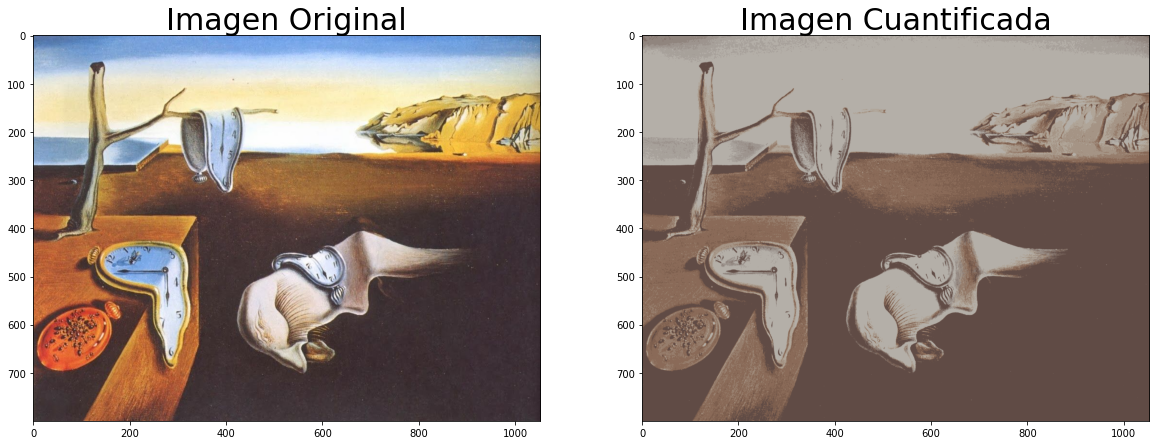

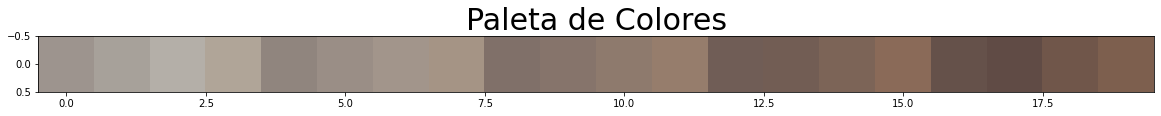

In [23]:
image_transformed(images[0])

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8307.89it/s]


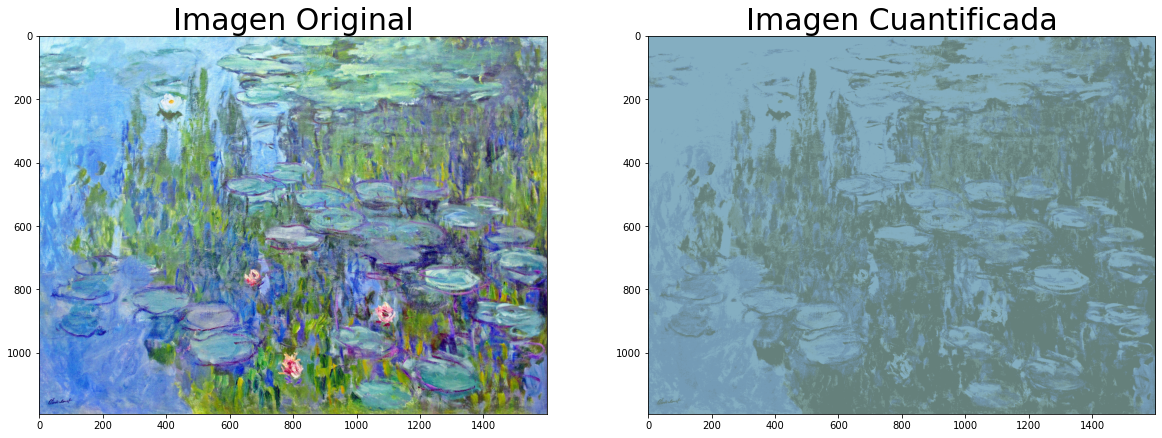

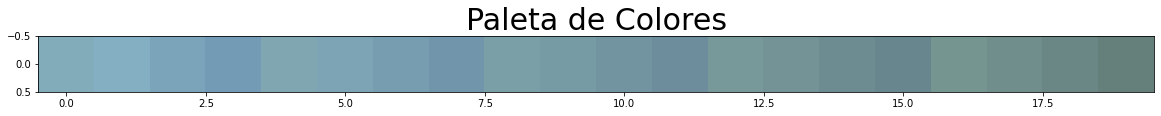

In [24]:
image_transformed(images[1])

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8341.62it/s]


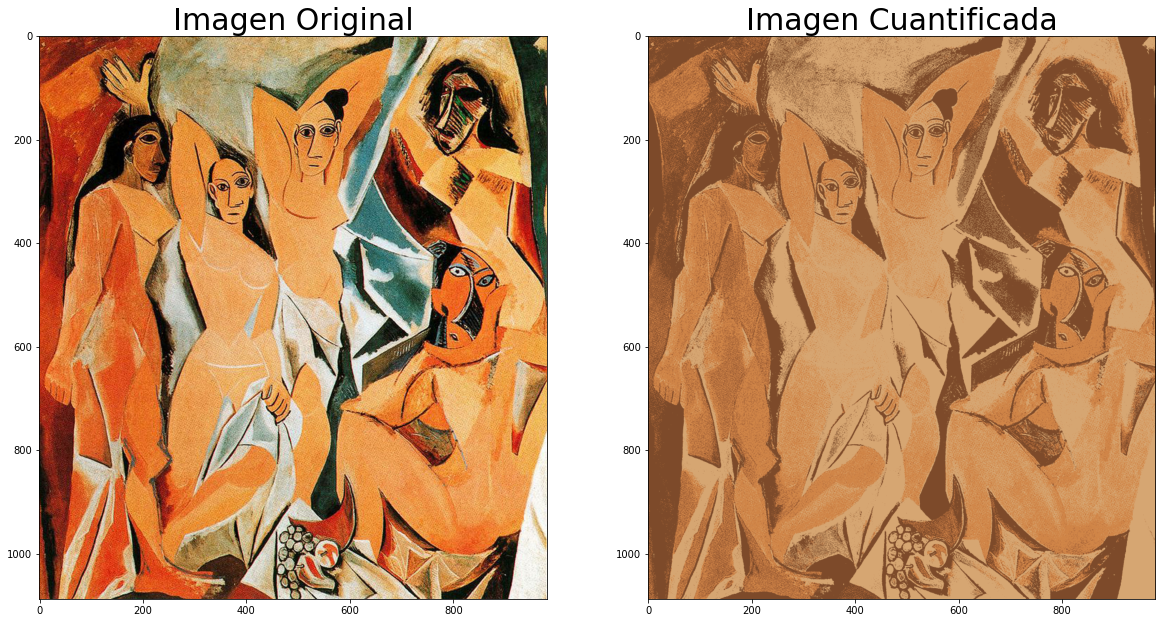

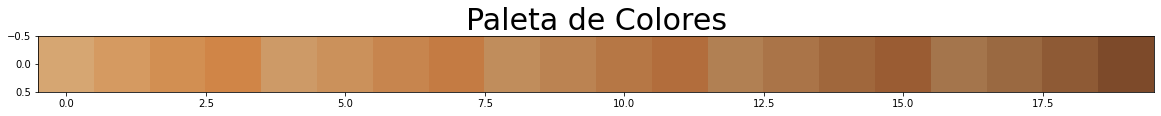

In [25]:
image_transformed(images[2])

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 13605.21it/s]


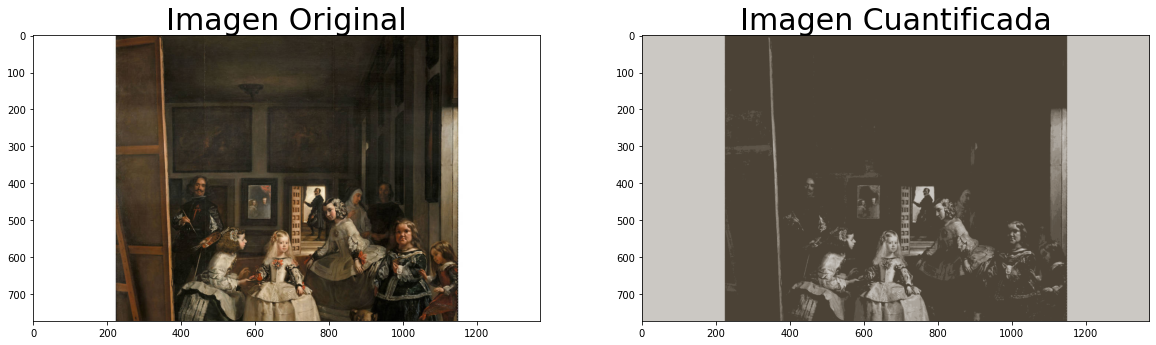

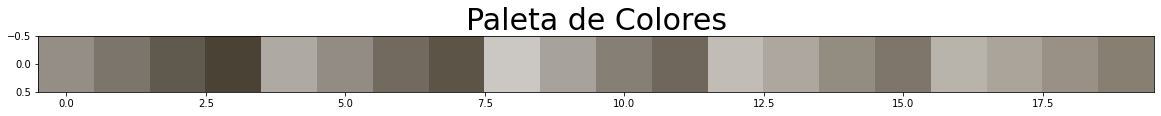

In [26]:
image_transformed(images[3])

Aquí podemos observar que por la forma en que se genera la paleta de colores, la imagen que se ve mejor es la de Picasso, dado que en la imagen cuantificada la forma de la pintura original sigue conservándose. La pintura de las meninas de Velázquez es la que probablemente menos se distingue dado que en la original hay muchos tonos oscuros que hacen que la cuantificada se vea demasiado oscura y no se logre observar con gran definición el resultado.

## Preguntas

**1. ¿Esta agusto con la cuantización realizada?**

No, si bien la cuantización realizada toma los tonos más predominantes en las respectivas imágenes, cada una de las pinturas cuantificadas se ven más opacas y pierden un poco la intensidad y la esencia de las pinturas originales. Además, hay pedazos de la figura cuantificada que no se logra apreciar de la mejor manera.

**2. ¿Cómo puede mejorar los resultados?** 

Una manera de mejorar los resultados, es estudiando bien la ubicación de la imagen. Es decir, si se fija solo en los colores, se pueden perder alguna texturas o formas que al fin y al cabo, terminaría siendo otra pintura. Por ejemplo, note que en la primera imagén, el cielo que está de fondo, al ser cuantificada se pierde y queda como un fondo unicolor, cosa que no pasa en realidad. Así pues, considerando las texturas y las formas de los trazos de las pinturas se lograría disminuir el cambio abrupto de la pintura. También, se podría tener en cuenta las pinturas que tienen difuminados. Dado que el algoritmo busca un promedio del color, no se lograría ver 

**3. Describa brevemente que han hecho los mapas autoorganizados. Puede usar figuras, gráficas, etc para complementar esta respuesta.** 

Los mapas auto-organizados sirven para particionar el espacio donde se encuentran los datos con los que se están trabajando en regiones de elementos similares, sin determinar cuantos clusters deben haber. De esta manera, logra reducir y promediar los datos con el fin de que sean más accesibles o más fáciles al trabajarlos.

En este caso de las pinturas, una pintura está conformada por demasiados colores. Computacionalmente, es un gasto de memoria por lo que usualmente, se limita la cantidad de colores con los que van a trabajar. Por medio de los mapas auto-organizados, se busca reducir este número gigante de colores, encontrando una combinación que se aproxime al color con el que originalemente se estaba trabajando. Específicamente, esta técnica se llama cuantización del color. Como se vio en las anteriores imágenes, la imagén cuantizada no tiene buena resolución dado que se trabajan con apenas 20 tonos. Sin embargo, es una aproximación a la pintura original. 

**4. ¿Qué problemas tuvo a la hora de realizar esta parte del proyecto?**

Principalmente, los problemas obtenidos fue a la hora de poder utilizar las librerías propuestas por el profesor. La documentación no era clara en su totalidad y a la hora de importarlas no se lograban utilizar de una buena manera. Por ende, lo que se propuso fue utilizar otra librería encontrada en https://github.com/damiankucharski/Tiny-SOM que era fácil de utilizar, crear un mapa de color con esta librería y poder identificar el mejor color para cada uno de los pixeles de la imagen con el método `pairwise_distances` de `sklearn.metrics`. Así, el resto de procedimiento y volver a reconstruir la imagen fue mucho más ameno.

In [118]:
'''
1. ¿Esta agusto con la cuantización realizada?
No # Yo

2. ¿Cómo puede mejorar los resultados?
No sólo mirar los colores que hay si no la ubicación (buscar cuantización del color), las formas.
# Pau

3. Describa brevemente que han hecho los mapas autoorganizados. Puede usar figuras, gráficas, etc para complementar esta respuesta.
# Pau

4. ¿Qué problemas tuvo a la hora de realizar esta parte del proyecto?
PUTAS LIBRERIAS
# yo
'''

'\n1. ¿Esta agusto con la cuantización realizada?\nNo # Yo\n\n2. ¿Cómo puede mejorar los resultados?\nNo sólo mirar los colores que hay si no la ubicación (buscar cuantización del color), las formas.\n# Pau\n\n3. Describa brevemente que han hecho los mapas autoorganizados. Puede usar figuras, gráficas, etc para complementar esta respuesta.\n# Pau\n\n4. ¿Qué problemas tuvo a la hora de realizar esta parte del proyecto?\nPUTAS LIBRERIAS\n# yo\n'